In [1]:
from IPython import display

# kill error when executing argparse in IPython console
import sys; sys.argv=['']; del sys

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from torchsampler import ImbalancedDatasetSampler

dataset_path="/home/elliot/dataset/pytorch"

In [7]:
import argparse
import random
import copy
import torch
import torchvision
import numpy as np
import pandas as pd
import sklearn.metrics as sm
import torch.nn.functional as F

# parse arguments
parser = argparse.ArgumentParser(description='Imbalanced MNIST Example')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                    help='number of epochs to train')
parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                    help='learning rate (default: 0.01)')
parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                    help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=42, metavar='S',
                    help='random seed (default: 42)')
args = parser.parse_args()
use_cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# load data
test_seq = [
   torchvision.transforms.ToTensor(),
   torchvision.transforms.Normalize((0.1307,), (0.3081,))
]
test_transform = torchvision.transforms.Compose(test_seq)
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomAffine(
        10, shear=10
    )] + test_seq)
train_dataset = torchvision.datasets.MNIST(dataset_path, train=True, download=True, transform=train_transform)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(dataset_path, train=False, transform=test_transform),
    batch_size=args.test_batch_size, shuffle=True, **kwargs)

# make imbalanced data
torch.manual_seed(args.seed)
num_classes = 10
classe_labels = range(num_classes)
sample_probs = torch.rand(num_classes)
print(sample_probs)


idx_to_del = [i for i, label in enumerate(train_loader.dataset.train_labels) 
              if random.random() > sample_probs[label]]
imbalanced_train_dataset = copy.deepcopy(train_dataset)

# original implementation
# imbalanced_train_dataset.train_labels = np.delete(train_loader.dataset.train_labels, idx_to_del, axis=0)
# imbalanced_train_dataset.train_data = np.delete(train_loader.dataset.train_data, idx_to_del, axis=0)
# imbalanced_train_loader = torch.utils.data.DataLoader(
#     imbalanced_train_dataset, batch_size=args.batch_size, shuffle=True, **kwargs)

imbalanced_train_dataset.train_labels.data = np.delete(train_loader.dataset.train_labels, idx_to_del, axis=0).data
imbalanced_train_dataset.train_data.data = np.delete(train_loader.dataset.train_data, idx_to_del, axis=0).data
imbalanced_train_loader = torch.utils.data.DataLoader(
    imbalanced_train_dataset, batch_size=args.batch_size, shuffle=True, **kwargs)

tensor([0.8823, 0.9150, 0.3829, 0.9593, 0.3904, 0.6009, 0.2566, 0.7936, 0.9408,
        0.1332])


In [3]:

print('number of samples left:', 60000 - idx_to_del.__len__())
# train_loader.dataset
imbalanced_train_dataset


number of samples left: 37817


Dataset MNIST
    Number of datapoints: 37817
    Root location: /home/elliot/dataset/pytorch
    Split: Train
    StandardTransform
Transform: Compose(
               RandomAffine(degrees=[-10.0, 10.0], shear=[-10.0, 10.0])
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

Original dataset: 60000 training samples & 10000 testing samples

Distribution of classes in original dataset:


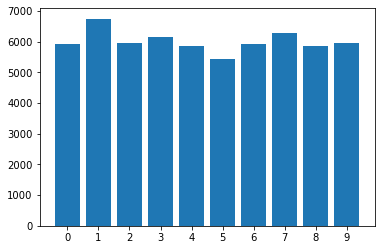

Sampling probability for each class:


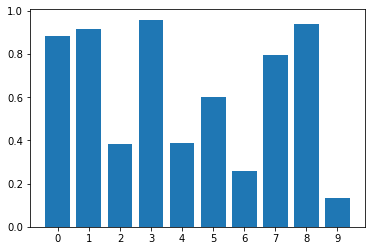

Imbalanced dataset: 37817 training samples & 10000 testing samples

Distribution of classes in imbalanced dataset:


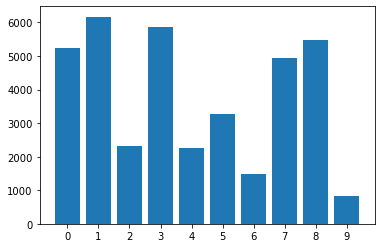

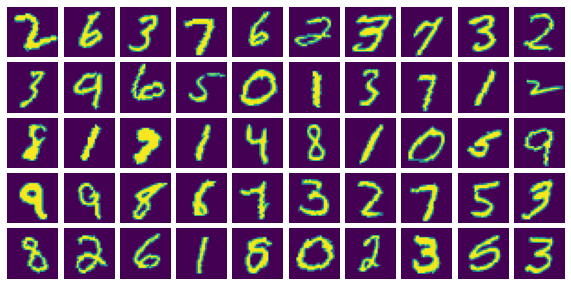

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

!pip install seaborn
import seaborn as sns

def show_mnist(arr, nrow=5, ncol=10, figsize=None):
    
    if figsize is None:
        figsize = (ncol, nrow)
        
    f, a = plt.subplots(nrow, ncol, figsize=figsize)
    
    def _do_show(the_figure, the_array):
        the_figure.imshow(the_array)
        the_figure.axis('off')
    
    for i in range(nrow):
        for j in range(ncol):
            _do_show(a[i][j], np.reshape(arr[i * ncol + j], (28, 28)))
            
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.draw()
        
    
def vis(test_accs, confusion_mtxes, labels, figsize=(20, 8)):
    
    cm = confusion_mtxes[np.argmax(test_accs)]
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%' % p
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    
    fig = plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.plot(test_accs, 'g')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    sns.heatmap(cm, annot=annot, fmt='', cmap="Blues")
    plt.show()
        
        
print('Original dataset: %d training samples & %d testing samples\n' % (
    len(train_loader.dataset), len(test_loader.dataset)))
 
print('Distribution of classes in original dataset:')
fig, ax = plt.subplots()
_, counts = np.unique(train_loader.dataset.train_labels, return_counts=True)
ax.bar(classe_labels, counts)
ax.set_xticks(classe_labels)
plt.show()

print('Sampling probability for each class:')
fig, ax = plt.subplots()
ax.bar(classe_labels, sample_probs)
ax.set_xticks(classe_labels)
plt.show()
 
print('Imbalanced dataset: %d training samples & %d testing samples\n' % (
    len(imbalanced_train_loader.dataset), len(test_loader.dataset)))

print('Distribution of classes in imbalanced dataset:')
fig, ax = plt.subplots()
_, counts = np.unique(imbalanced_train_loader.dataset.train_labels, return_counts=True)
ax.bar(classe_labels, counts)
ax.set_xticks(classe_labels)
plt.show()

for data, _ in train_loader:
    show_mnist(data)
    break
    

In [5]:
# define model & optimizer
from tqdm import tqdm

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = torch.nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = torch.nn.Dropout2d()
        self.fc1 = torch.nn.Linear(320, 50)
        self.fc2 = torch.nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
    
def process(train_loader, test_loader):
    
    model = Net().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

    # train & test process
    def train(train_loader):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

    def test(test_loader):
        model.eval()
        correct = 0
        targets, preds = [], []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()
                
                targets += list(target.cpu().numpy())
                preds += list(pred.cpu().numpy())

        test_acc = 100. * correct / len(test_loader.dataset)
        confusion_mtx = sm.confusion_matrix(targets, preds)
        return test_acc, confusion_mtx
    
    
    test_accs, confusion_mtxes = [], []    
    for epoch in tqdm(range(1, args.epochs + 1)):
        train(train_loader)
        test_acc, confusion_mtx = test(test_loader)
        test_accs.append(test_acc)
        confusion_mtxes.append(confusion_mtx)
        print('\rBest test acc = %2.2f%%' % max(test_accs), end='', flush=True)
        
    vis(test_accs, confusion_mtxes, classe_labels)
    # print(test_accs)
    print(test_accs, confusion_mtxes, classe_labels)

100%|██████████| 10/10 [02:01<00:00, 12.18s/it]


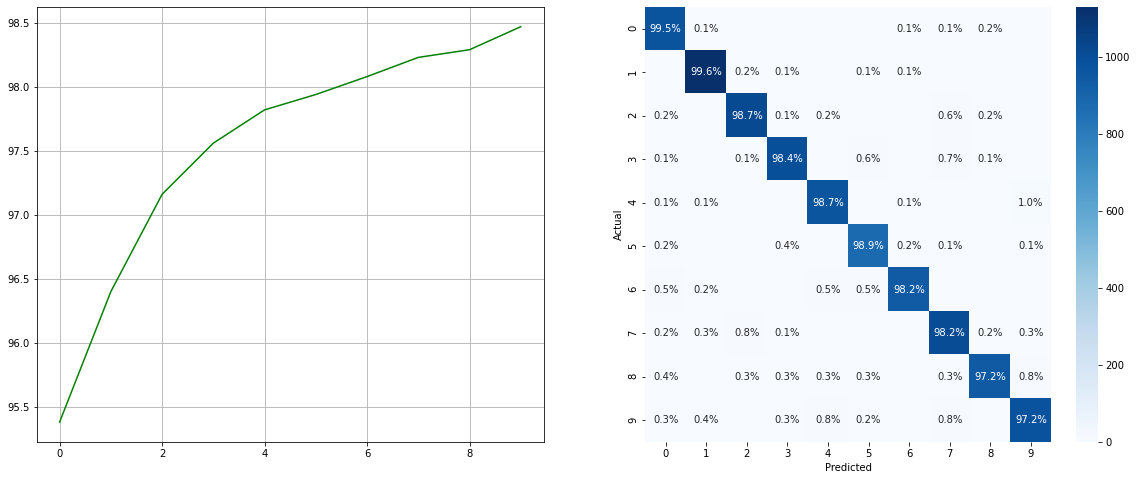

[95.38, 96.4, 97.16, 97.56, 97.82, 97.94, 98.08, 98.23, 98.29, 98.47] [array([[ 967,    0,    1,    0,    0,    0,    6,    1,    5,    0],
       [   0, 1121,    3,    2,    0,    1,    4,    1,    2,    1],
       [   9,    0,  964,    9,    6,    1,    8,   23,   12,    0],
       [   1,    0,   16,  961,    0,   15,    0,    9,    4,    4],
       [   1,    2,    2,    0,  946,    0,   11,    0,    2,   18],
       [  13,    1,    0,    9,    2,  845,    7,    3,   10,    2],
       [   8,    3,    0,    0,    7,    5,  933,    0,    2,    0],
       [   3,    6,   26,    2,    0,    2,    0,  967,    5,   17],
       [   8,    3,    5,    5,    6,    6,    5,   13,  901,   22],
       [   8,    4,    3,   11,   15,   15,    0,   13,    7,  933]]), array([[ 972,    1,    0,    0,    0,    1,    2,    1,    3,    0],
       [   0, 1125,    3,    3,    0,    2,    1,    0,    1,    0],
       [   8,    0,  984,    8,    4,    1,    6,   19,    2,    0],
       [   1,    0,    8,  977

In [6]:
process(train_loader, test_loader)

Best test acc = 99.13%

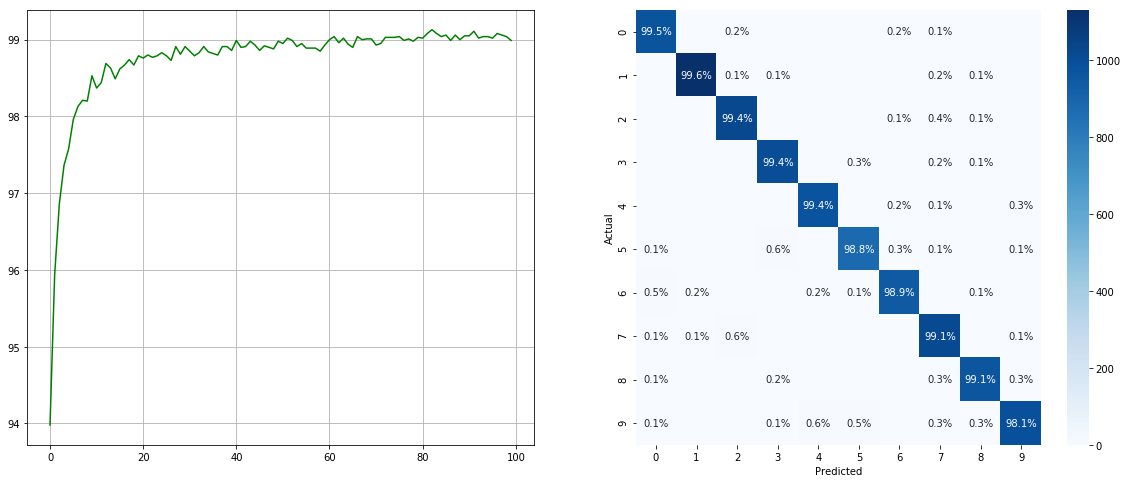

In [6]:
process(torch.utils.data.DataLoader(
    train_dataset, 
    sampler=ImbalancedDatasetSampler(train_dataset),
    batch_size=args.batch_size, **kwargs), test_loader)

Best test acc = 98.80%

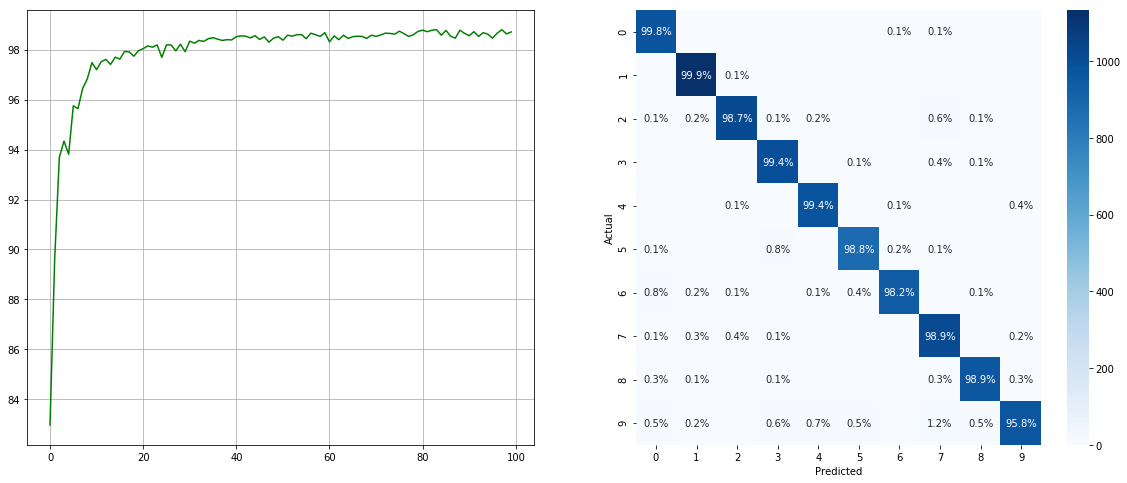

In [7]:
process(imbalanced_train_loader, test_loader)

Best test acc = 99.04%

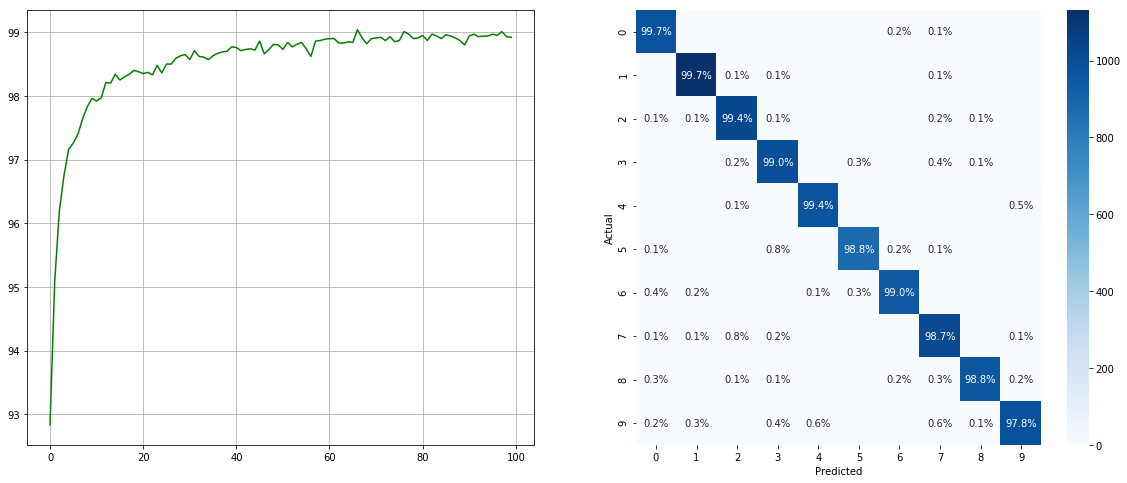

In [8]:
process(torch.utils.data.DataLoader(
    imbalanced_train_dataset, 
    sampler=ImbalancedDatasetSampler(imbalanced_train_dataset),
    batch_size=args.batch_size, **kwargs), test_loader)